### 1D Vert Model
We use a NED frame with **intrinsic** Y-P-R rotations ${}^{I}R_{B}=R_{\psi}R_{\theta}R_{\phi}$ with body frame and inertial frames aligned when there is **no rotation**.

$$
\begin{align}
m\ddot{Z} &= -F +mg \\
F & = F_1 + F_2 + F_3 + F_4
\end{align}
$$


In [100]:
import casadi as ca
import numpy as np
import cvxpy as cp
import control as ct
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import math

m = 1  # kg
g = 9.81  # m/s^2
dt=0.01 ## Simulate step at 100Hz

In [101]:
## Dynamics
x = ca.SX.sym("x", 2)
u = ca.SX.sym("u", 1)
x_z, x_dz = ca.vertsplit(x, 1)
u_F = u

dx_z = x_dz
dx_dz = -u_F/m + g

x_dot = ca.vertcat(dx_z, dx_dz)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

out = [-10, 0]
for i in range(0,100):
    out = dynamics(out, 15)
print(out)

[-12.569, -5.19]


In [140]:
## Controller
class Controller:
    '''Simple PI controller class'''
    def __init__(self, p, i, d, imax, title='(PID)', limit_lower=-1e9, limit_upper=1e9, scale_gains=True):
        self.kp = p
        self.ki = i
        self.kd = d
        self.imax = imax

        self.lower = limit_lower
        self.upper = limit_upper

        self.title=title

        self.cumulative_error = 0
        self.error_previous = None

        self.log = {'error': [], 'target': [], 'feedback': [], 'output': []}

        if scale_gains:
            ## Conversions from centi-degrees to radians
            self.kp *= 0.01*math.pi/180
            self.ki *= 0.01*math.pi/180
            self.kd *= 0.01*math.pi/180
            self.imax *= 0.01*math.pi/180

    def _clamp(self, val):
        return min(max(val,self.lower),self.upper)

    def __call__(self, target, feedback, dt):
        feedback = float(feedback)
        
        # Calculate error
        error = target - feedback

        ## TODO Is this the correct D and I term formulations??

        # Calculate D term
        if self.error_previous is not None:
            d_term = error - self.error_previous
        else:
            d_term = 0
        self.error_previous = error

        # Integrate error and check imax breach
        self.cumulative_error += error*dt*self.ki
        if abs(self.cumulative_error)>self.imax:
            self.cumulative_error = self.imax if self.cumulative_error > 0 else -self.imax

        output = self.kp*(error) + self.cumulative_error + (0 if dt==0 else self.kd*d_term/dt)

        ## Constrain output
        output = self._clamp(output)

        self.log['error'].append(float(error))
        self.log['target'].append(float(target))
        self.log['feedback'].append(float(feedback))
        self.log['output'].append(float(output))
        
        return output

    def plot(self, ax, color='blue'):
        ## TODO Add check to see what update rate of this PID controller is

        ## TODO Change this to increments of dt
        t = range(0,len(self.log['error']))
        ax.plot(t, self.log['error'], color='red', label='error', alpha=0.6)
        ax.plot(t, self.log['feedback'], color='purple', label='feedback', alpha=0.6)
        ax.plot(t, self.log['target'], color=color, linestyle='-.', label='target', alpha=0.6)
        ax.plot(t, self.log['output'], color='green', linestyle='--', label='output', alpha=0.6)
        ax.set_title(self.title)
        ax.grid()
        ax.legend()

        
    def reset_logging(self):
        self.log = {'error': [], 'target': [], 'feedback': [], 'output': []}
        
    def reset(self):
        self.cumulative_error = 0

## Limit the althold controller to +-10m/s and throttle
'''TUNING
Original values:
    [5,0,0,300], lim[-100,100]
    [6,0,0,300], lim[-320,320]
    [0.75,1.5,0,500], lim[-500,500]
'''
pi_alt_hold = Controller(5, 0, 0, 300, 'pi_alt_hold', -5, 5, scale_gains=False)
pid_throttle_rate = Controller(6, 0, 0, 300, 'pid_throttle_rate', -320, 320, scale_gains=False)
pid_throttle_accel = Controller(20, 10, 0, 5000, 'pid_throttle_accel', -10, 10, scale_gains=False)

## Array to easily call reset on all controllers
controller_array = [pi_alt_hold, pid_throttle_rate, pid_throttle_accel]

[[-1.00000000e+01 -1.00006308e+01 -1.00002806e+01 ... -1.20468546e+03
  -1.20498002e+03 -1.20527559e+03]
 [-6.30795280e-02  3.50204720e-02 -1.94879528e-01 ... -2.94554817e+01
  -2.95575817e+01 -2.94594817e+01]]


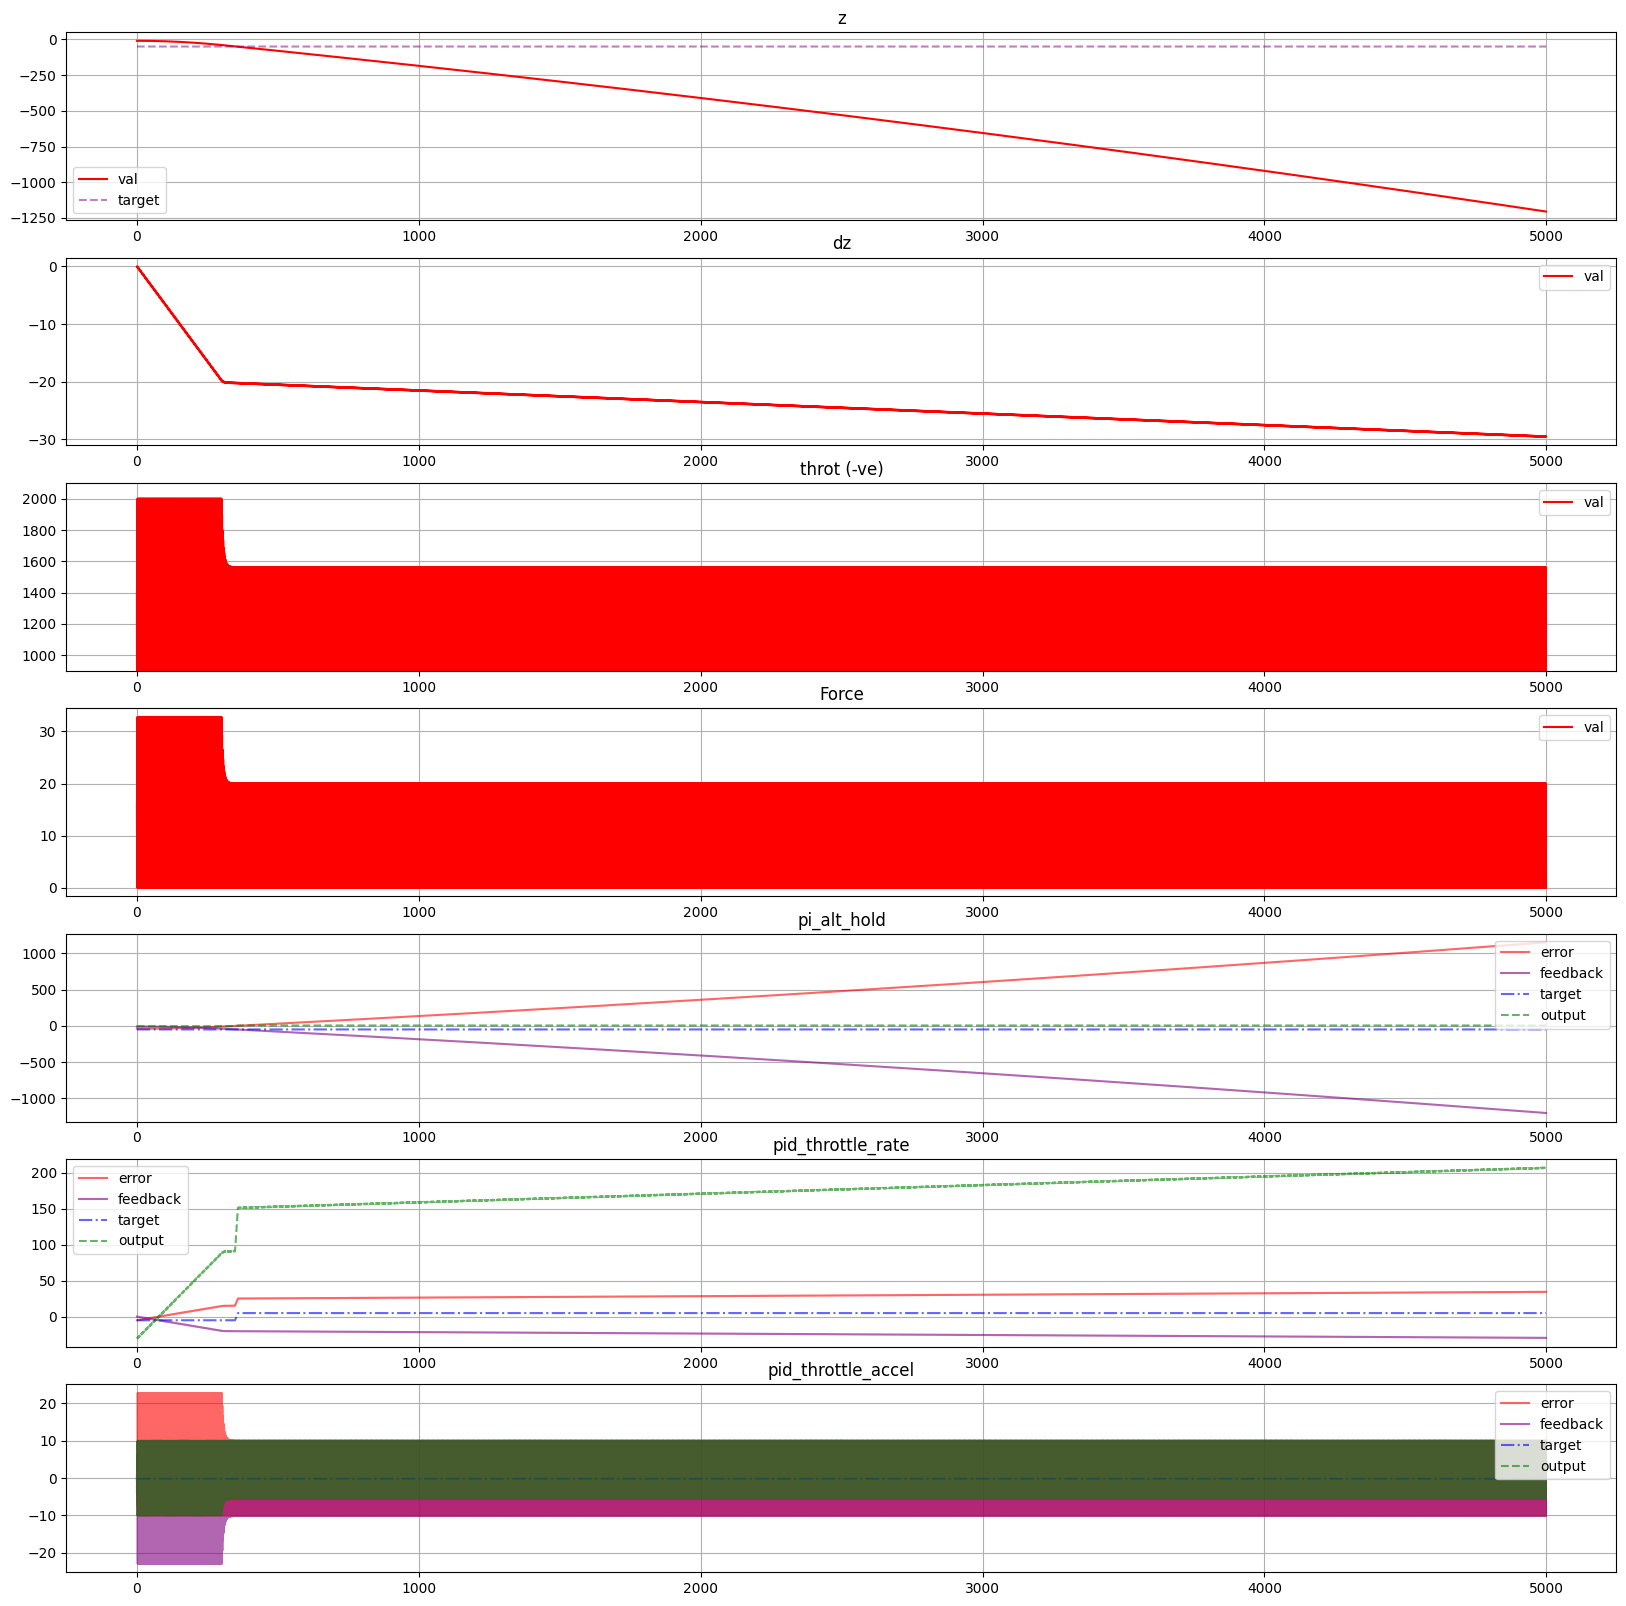

In [141]:
iterations=50*100

## z and dz
temp_x = np.zeros((2, iterations))
throttle = np.zeros((1,iterations))
u_f = np.zeros((1,iterations))
out = [-10, 0]
target_z = -50
prev_dz_meas = 0

for c in controller_array:
    c.reset()
    c.reset_logging()
    
for i in range(0,iterations):
    ## THROTTLE Control
    ## NOTE These are both P-controllers so dt is ignored
    desired_throttle_rate = pi_alt_hold(target_z, out[0], 0)
    desired_throttle_accel = pid_throttle_rate(desired_throttle_rate, out[1], 0)

    ##################### Testing only throttle controller #####################
    desired_throttle_accel = -0.2 ## m/s2
    
    ## NOTE In this model, we don't explictly have the IMU reading so we don't have dd-z (z-accel) so
    ## we instead use an approx w 3 previous velocity measurements
    accel_estimate = (out[1]-prev_dz_meas)/dt
    rthrottle_output = pid_throttle_accel(desired_throttle_accel, accel_estimate, dt)

    ## This rthrottle_output is constrained [-1,1] so we scale up to [-1000,1000]
    rthrottle_output *= 100
    rthrottle_output -= 1000
    prev_dz_meas = out[1]

    ## Conversion to force
    ## NOTE Normally, rthrottle_output should be negated as we want out out_f to be a positive number as per dynamics (which use -F)
    kt = 2.05*1e-6
    out_f = 4*kt*rthrottle_output**2

    ## Dynamics
    out = dynamics(out, out_f)
    out = np.array([out.full()[0], out.full()[1]]).reshape((2,))

    temp_x[:,i] = out
    throttle[:,i] = np.array([rthrottle_output])
    u_f[:,i] = np.array([out_f])

print(temp_x)

# Visualisation - Intermediate variables
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(7, 1, figure=fig)

for i, e in enumerate(['z','dz']):
    ax = fig.add_subplot(gs[i, 0])
    t = range(0,iterations)
    ax.plot(t, temp_x[i,:], color='red', label='val')
    ax.set_title(e)
    ax.grid()

    if e=='z':
        ax.plot(t, len(t)*[-50], linestyle='--', alpha=0.5, color='purple', label='target')
    
    ax.legend()


ax = fig.add_subplot(gs[2,0])
t = range(0,iterations)
ax.plot(t, -throttle[0,:], color='red', label='val')
ax.set_title('throt (-ve)')
ax.set_ylim(900,2100)
ax.legend()
ax.grid()

ax = fig.add_subplot(gs[3,0])
t = range(0,iterations)
ax.plot(t, u_f[0,:], color='red', label='val')
ax.set_title('Force')
ax.legend()
ax.grid()

controller_array[0].plot(fig.add_subplot(gs[4,0]))
controller_array[1].plot(fig.add_subplot(gs[5,0]))
controller_array[2].plot(fig.add_subplot(gs[6,0]))

plt.show()

In [136]:
print(m,g)
print(4*kt*(-100**2))
print([4*kt*(1000**2) - m*g, 4*kt*(2000**2) - m*g])

1 9.81
-0.08199999999999999
[-1.6100000000000012, 22.989999999999995]
